# Figure 4

In [97]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [98]:
import numpy as np
import matplotlib.pylab as plt
import torch
import time
from copy import deepcopy
import sys
sys.path.append("../../../setup")
sys.path.append("../../../simulator")
sys.path.append("../../../inference")
sys.path.append("../../../utils")
sys.path.append("../model/")
sys.path.append('../../')

from common import col, svg, samples_nd
import netio
import viz
import importlib
from compare_samples import get_dist, evaluate_summ_stats
from find_pyloric import merge_samples, params_are_bounded
import dill as pickle
from find_pyloric import merge_datasets, merge_datasets_energy, find_pyloric_like, find_close_to_obs
from energy import select_ss_close_to_obs

import matplotlib as mpl

In [99]:
from helper_functions import prepare_data, regression_plot, get_gradient

In [100]:
PANEL_A  = '../svg/panel_a.svg'
PANEL_B1 = '../svg/panel_b1.svg'
PANEL_B2 = '../svg/panel_b2.svg'
PANEL_C1 = '../svg/panel_c1.svg'
PANEL_C2 = '../svg/panel_c2.svg'
PANEL_D1 = '../svg/panel_d1.svg'
PANEL_D2 = '../svg/panel_d2.svg'
PANEL_D3 = '../svg/panel_d3.svg'
PANEL_D4 = '../svg/panel_d4.svg'
PANEL_supp1 = '../svg/panel_supp1.svg'
PANEL_supp2 = '../svg/panel_supp2.svg'

In [101]:
params_11 = netio.load_setup('collect_31D')
pyloric_sim_11 = netio.create_simulators(params_11, save_all_energies=True)
energy_calc = netio.create_energy(params_11)

### Sort out the data from the cluster

In [102]:
outfile = '../../results/11deg_post_pred/11_deg_post_pred_close_to_obs.npz'
data_n = np.load(outfile)
sample_seeds = data_n["sample_seeds"]
sample_params = data_n["sample_params"]
sample_stats = data_n["sample_stats"]
print('There are', len(sample_seeds), 'datapoints in this dataset')

There are 55043 datapoints in this dataset


# Train regression net

### Prepare parameters

In [103]:
num_test = 500

test_params = sample_params[:num_test]
train_params = sample_params[num_test:]
mean_params = np.mean(train_params, axis=0)
std_params = np.std(train_params, axis=0)

train_params_norm = (train_params - mean_params) / std_params
test_params_norm = (test_params - mean_params) / std_params

### Prepare energy/spike

In [104]:
all_energies_per_spike_ABPD = sample_stats[:, 18]

In [105]:
numSpikesPerBurst = sample_stats[:, -6] / sample_stats[:, -3]

In [106]:
(mean_energies_per_spike, 
std_energies_per_spike, 
train_energies_per_spike_norm,
test_energies_per_spike_norm,
mean_num_spikes,
std_num_spikes,
train_num_spikes_norm,
test_num_spikes_norm) = prepare_data(all_energies_per_spike_ABPD, numSpikesPerBurst, num_test)

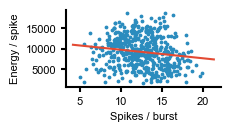

In [107]:
unnorm_x_vals, unnorm_y_regs, unnorm_x, unnorm_y = regression_plot(
    mean_energies_per_spike, 
    std_energies_per_spike, 
    train_energies_per_spike_norm,
    test_energies_per_spike_norm,
    mean_num_spikes,
    std_num_spikes,
    train_num_spikes_norm,
    test_num_spikes_norm
)


with mpl.rc_context(fname='../../.matplotlibrc'):
    fig, ax = plt.subplots(1,1, figsize=(2,1.0))
    ax.scatter(x=unnorm_x, y=unnorm_y, s=3, color='#2b8cbe')
    ax.plot(unnorm_x_vals, unnorm_y_regs, '#e34a33')
    ax.set_xlabel('Spikes / burst')
    ax.set_ylabel('Energy / spike')
    #plt.savefig(PANEL_A, facecolor='None', transparent=True)
    plt.show()

### Train classifier

In [108]:
nn = classifier(dim=31)

In [109]:
# converged_nn = fit_regression_net(
#     nn, 
#     train_params_norm, 
#     train_energies_per_spike_norm, 
#     num_train=train_params_norm.shape[0],
#     batch_size=50, 
#     stop_after_epochs=10, 
#     max_epochs=200
# )

In [110]:
#np.savez('../../results/regression_nets/200821_predict_energyPerSpike_ABPD.npz', converged_nn=converged_nn)

In [111]:
data = np.load('../../results/regression_nets/200821_predict_energyPerSpike_ABPD.npz', allow_pickle=True)
converged_nn = data['converged_nn'].tolist()

In [112]:
predictions = converged_nn.predict(torch.as_tensor(test_params_norm)).detach().numpy()

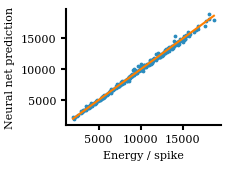

In [113]:
with mpl.rc_context(fname='../../.matplotlibrc'):
    fig, ax = plt.subplots(1,1, figsize=(2,1.5))
    unnorm_x = test_energies_per_spike_norm[:300] * std_energies_per_spike + mean_energies_per_spike
    unnorm_y = predictions[:300] * std_energies_per_spike + mean_energies_per_spike
    ax.scatter(x=unnorm_x, y=unnorm_y, s=3, color='#2b8cbe')
    gt_vec = np.linspace(np.min(unnorm_x), np.max(unnorm_x), 2)
    ax.plot(gt_vec, gt_vec, '#ff7f00')
    ax.set_xlabel('Energy / spike')
    ax.set_ylabel('Neural net prediction')
    plt.savefig(PANEL_supp1, facecolor='None', transparent=True)

### Get gradient wrt input

In [114]:
cum_grad = get_gradient(converged_nn, test_params_norm)

# Panel B: Sensitivity energy/spike

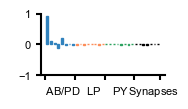

In [115]:
with mpl.rc_context(fname='../../.matplotlibrc'):
    viz.all_sensitivity_bars(cum_grad, ylim=[-1,1], figsize=(1.6, 0.8))
    plt.savefig(PANEL_B1, facecolor='None', transparent=True)
    plt.show()

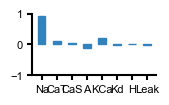

In [116]:
with mpl.rc_context(fname='../../.matplotlibrc'):
    viz.single_neuron_sensitivity_bar(cum_grad, ylim=[-1,1], figsize=(1.6, 0.8))
    plt.savefig(PANEL_B2, facecolor='None', transparent=True)
    plt.show()

# Panel C: sensitivity number of spikes

In [117]:
nn = classifier(dim=31)

In [118]:
# converged_nn_num_spikes = fit_regression_net(
#     nn,
#     train_params_norm,
#     train_num_spikes_norm,
#     num_train=train_params_norm.shape[0],
#     batch_size=50,
#     stop_after_epochs=10,
#     max_epochs=200
# )

In [119]:
# np.savez('../../results/regression_nets/200821_predict_numSpikes_ABPD.npz', converged_nn=converged_nn_num_spikes)

In [120]:
data = np.load('../../results/regression_nets/200821_predict_numSpikes_ABPD.npz', allow_pickle=True)
converged_nn_num_spikes = data['converged_nn'].tolist()

In [121]:
predictions = converged_nn_num_spikes.predict(torch.as_tensor(test_params_norm)).detach().numpy()

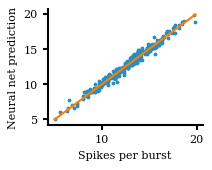

In [122]:
with mpl.rc_context(fname='../../.matplotlibrc'):
    fig, ax = plt.subplots(1,1, figsize=(2,1.5))
    unnorm_x = test_num_spikes_norm[:300] * std_num_spikes + mean_num_spikes
    unnorm_y = predictions[:300] * std_num_spikes + mean_num_spikes
    ax.scatter(x=unnorm_x, y=unnorm_y, s=3, color='#2b8cbe')
    gt_vec = np.linspace(np.min(unnorm_x), np.max(unnorm_x), 2)
    ax.plot(gt_vec, gt_vec, '#ff7f00')
    ax.set_xlabel('Spikes per burst')
    ax.set_ylabel('Neural net prediction')
    plt.savefig(PANEL_supp2, facecolor='None', transparent=True)

### Get gradient wrt output

In [123]:
cum_grad = get_gradient(converged_nn_num_spikes, test_params_norm)

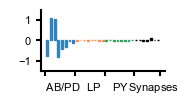

In [124]:
with mpl.rc_context(fname='../../.matplotlibrc'):
    viz.all_sensitivity_bars(cum_grad, ylim=[-1.5, 1.5], figsize=(1.6, 0.8))
    plt.savefig(PANEL_C1, facecolor='None', transparent=True)
    plt.show()

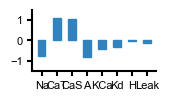

In [125]:
with mpl.rc_context(fname='../../.matplotlibrc'):
    viz.single_neuron_sensitivity_bar(cum_grad, ylim=[-1.5,1.5], figsize=(1.6, 0.8))
    plt.savefig(PANEL_C2, facecolor='None', transparent=True)
    plt.show()

# Panel D: num spikes and energy per spike independent

In [126]:
quantile_energy    = 0.05
quantile_numSpikes = 0.05

In [36]:
data = np.load('../../results/11deg_post_pred/11_deg_post_pred_close_to_obs.npz')
sample_stats = data['sample_stats']
sample_params = data['sample_params']
sample_seeds = data['sample_seeds']

In [37]:
all_energies_per_spike = sample_stats[:, 18:21]
all_total_energies     = sample_stats[:, 21:24]
summed_energies_per_spike = np.sum(np.asarray(all_energies_per_spike), axis=1)
summed_energies_total     = np.sum(np.asarray(all_total_energies), axis=1)

In [38]:
energies_per_spike_PY = all_energies_per_spike[:,-1]
all_numbers_of_spikes_per_burst = sample_stats[:, -6:-3] / sample_stats[:, -3:]
number_of_spikes_per_burst_PY = all_numbers_of_spikes_per_burst[:, -1]

In [39]:
inds_energy_per_spike = np.argsort(energies_per_spike_PY)
inds_num_spikes = np.argsort(number_of_spikes_per_burst_PY)

In [40]:
index_energy_per_spike = inds_energy_per_spike[int(len(inds_energy_per_spike)*quantile_energy)]
index_num_spikes = inds_num_spikes[int(len(inds_num_spikes)*quantile_numSpikes)]

In [41]:
energy_per_spike_threshold = energies_per_spike_PY[index_energy_per_spike]
num_spikes_threshold = number_of_spikes_per_burst_PY[index_num_spikes]

In [42]:
param_sets_with_low_energy = sample_params[energies_per_spike_PY < energy_per_spike_threshold]
param_sets_with_low_num_spikes = sample_params[number_of_spikes_per_burst_PY < num_spikes_threshold]

In [43]:
print(param_sets_with_low_energy.shape)
print(param_sets_with_low_num_spikes.shape)

(2752, 31)
(2686, 31)


In [44]:
number_of_spikes_per_burst_PY_low_energy = number_of_spikes_per_burst_PY[energies_per_spike_PY < energy_per_spike_threshold]
params_both_low = param_sets_with_low_energy[number_of_spikes_per_burst_PY_low_energy < num_spikes_threshold]

In [45]:
print(params_both_low.shape)

(91, 31)


In [46]:
all_out_targets = []
cols = [col['CONSISTENT1'], col['CONSISTENT1']]

params1 = params_both_low[0]

target_params = params1# * params_std_11 + params_mean_11
out_target = pyloric_sim_11[0].gen_single(deepcopy(target_params), seed_sim=True, to_seed=0)

all_out_targets.append(out_target)

In [47]:
with mpl.rc_context(fname='../../.matplotlibrc'):
    viz.plot_energy_scape(out_target, 2, pyloric_sim_11[0].t, 109000, 129000, figsize=(2.5, 1.5), xlabel=False, ylabel=True)
    plt.savefig(PANEL_D1, facecolor='None', transparent=True)
    plt.show()

KeyError: 'all_energies'

In [39]:
quantile_energy    = 1-0.05
quantile_numSpikes = 0.05

In [40]:
index_energy_per_spike = inds_energy_per_spike[int(len(inds_energy_per_spike)*quantile_energy)]
index_num_spikes = inds_num_spikes[int(len(inds_num_spikes)*quantile_numSpikes)]

energy_per_spike_threshold = energies_per_spike_PY[index_energy_per_spike]
num_spikes_threshold = number_of_spikes_per_burst_PY[index_num_spikes]

param_sets_with_low_energy = sample_params[energies_per_spike_PY > energy_per_spike_threshold]
param_sets_with_low_num_spikes = sample_params[number_of_spikes_per_burst_PY < num_spikes_threshold]

print(param_sets_with_low_energy.shape)
print(param_sets_with_low_num_spikes.shape)

(2752, 31)
(2686, 31)


In [41]:
number_of_spikes_per_burst_PY_low_energy = number_of_spikes_per_burst_PY[energies_per_spike_PY > energy_per_spike_threshold]
params_both_low = param_sets_with_low_energy[number_of_spikes_per_burst_PY_low_energy < num_spikes_threshold]

print(params_both_low.shape)

(3, 31)


In [42]:
all_out_targets = []
cols = [col['CONSISTENT1'], col['CONSISTENT1']]

params1 = params_both_low[0]

target_params = params1# * params_std_11 + params_mean_11
out_target = pyloric_sim_11[0].gen_single(deepcopy(target_params), seed_sim=True, to_seed=0)

all_out_targets.append(out_target)

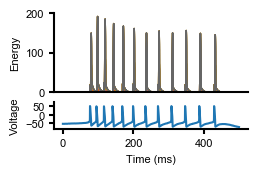

In [43]:
with mpl.rc_context(fname='../../.matplotlibrc'):
    viz.plot_energy_scape(out_target, 2, pyloric_sim_11[0].t, 108000, 128000, figsize=(2.5, 1.5), xlabel=True, ylabel=True)
    plt.savefig(PANEL_D2, facecolor='None', transparent=True)
    plt.show()

In [44]:
quantile_energy    = 0.05
quantile_numSpikes = 1-0.05

In [45]:
index_energy_per_spike = inds_energy_per_spike[int(len(inds_energy_per_spike)*quantile_energy)]
index_num_spikes = inds_num_spikes[int(len(inds_num_spikes)*quantile_numSpikes)]

energy_per_spike_threshold = energies_per_spike_PY[index_energy_per_spike]
num_spikes_threshold = number_of_spikes_per_burst_PY[index_num_spikes]

param_sets_with_low_energy = sample_params[energies_per_spike_PY < energy_per_spike_threshold]
param_sets_with_low_num_spikes = sample_params[number_of_spikes_per_burst_PY > num_spikes_threshold]

print(param_sets_with_low_energy.shape)
print(param_sets_with_low_num_spikes.shape)

(2752, 31)
(2659, 31)


In [46]:
number_of_spikes_per_burst_PY_low_energy = number_of_spikes_per_burst_PY[energies_per_spike_PY < energy_per_spike_threshold]
params_both_low = param_sets_with_low_energy[number_of_spikes_per_burst_PY_low_energy > num_spikes_threshold]

print(params_both_low.shape)

(188, 31)


In [47]:
all_out_targets = []
cols = [col['CONSISTENT1'], col['CONSISTENT1']]

params1 = params_both_low[0]

target_params = params1# * params_std_11 + params_mean_11
out_target = pyloric_sim_11[0].gen_single(deepcopy(target_params), seed_sim=True, to_seed=0)

all_out_targets.append(out_target)

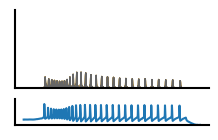

In [48]:
with mpl.rc_context(fname='../../.matplotlibrc'):
    viz.plot_energy_scape(out_target, 2, pyloric_sim_11[0].t, 114000, 134000, figsize=(2.5, 1.5), xlabel=False, ylabel=False)
    plt.savefig(PANEL_D3, facecolor='None', transparent=True)
    plt.show()

In [49]:
quantile_energy    = 1-0.05
quantile_numSpikes = 1-0.05

In [50]:
index_energy_per_spike = inds_energy_per_spike[int(len(inds_energy_per_spike)*quantile_energy)]
index_num_spikes = inds_num_spikes[int(len(inds_num_spikes)*quantile_numSpikes)]

energy_per_spike_threshold = energies_per_spike_PY[index_energy_per_spike]
num_spikes_threshold = number_of_spikes_per_burst_PY[index_num_spikes]

param_sets_with_low_energy = sample_params[energies_per_spike_PY > energy_per_spike_threshold]
param_sets_with_low_num_spikes = sample_params[number_of_spikes_per_burst_PY > num_spikes_threshold]

print(param_sets_with_low_energy.shape)
print(param_sets_with_low_num_spikes.shape)

(2752, 31)
(2659, 31)


In [51]:
number_of_spikes_per_burst_PY_low_energy = number_of_spikes_per_burst_PY[energies_per_spike_PY > energy_per_spike_threshold]
params_both_low = param_sets_with_low_energy[number_of_spikes_per_burst_PY_low_energy > num_spikes_threshold]

print(params_both_low.shape)

(17, 31)


In [52]:
all_out_targets = []
cols = [col['CONSISTENT1'], col['CONSISTENT1']]

params1 = params_both_low[0]

target_params = params1# * params_std_11 + params_mean_11
out_target = pyloric_sim_11[0].gen_single(deepcopy(target_params), seed_sim=True, to_seed=0)

all_out_targets.append(out_target)

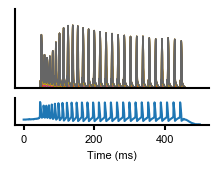

In [53]:
with mpl.rc_context(fname='../../.matplotlibrc'):
    viz.plot_energy_scape(out_target, 2, pyloric_sim_11[0].t, 100000, 120000, figsize=(2.5, 1.5), xlabel=True, ylabel=False)
    plt.savefig(PANEL_D4, facecolor='None', transparent=True)
    plt.show()

# Assembe figure

In [127]:
import time
import IPython.display as IPd

def svg(img):
    IPd.display(IPd.HTML('<img src="{}" / >'.format(img, time.time())))

In [128]:
from svgutils.compose import *

# > Inkscape pixel is 1/90 of an inch, other software usually uses 1/72.
# > http://www.inkscapeforum.com/viewtopic.php?f=6&t=5964
svg_scale = 1.25  # set this to 1.25 for Inkscape, 1.0 otherwise
factor_svg=5.5

# Panel letters in Helvetica Neue, 12pt, Medium
kwargs_text = {'size': '12pt', 'font': 'Arial', 'weight': '800'}
kwargs_consistent = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#AF99EF'}
kwargs_consistent1 = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#9E7DD5'}
kwargs_inconsistent = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#AF99EF'}
kwargs_text8pt = {'size': '7.7pt', 'font': 'Arial'}

f = Figure("20.3cm", "7.9cm",

    Panel(
         SVG(PANEL_A).scale(svg_scale).move(0, 0*factor_svg),
         Text("a", -2.0*factor_svg, 2.5*factor_svg, **kwargs_text),
    ).move(2*factor_svg, 0.0*factor_svg),
    
    Panel(
        SVG(PANEL_B1).scale(svg_scale).move(0*factor_svg, 0*factor_svg),
        Text("b", 0.0*factor_svg, 1.5*factor_svg, **kwargs_text),
    ).move(0*factor_svg, 22.0*factor_svg),
           
    Panel(
        SVG(PANEL_B2).scale(svg_scale).move(0*factor_svg, 0*factor_svg),
    ).move(28*factor_svg, 22.0*factor_svg),
    
    Panel(
          SVG(PANEL_C1).scale(svg_scale).move(0*factor_svg,0*factor_svg),
          Text("c", 0.0*factor_svg, 1.5*factor_svg, **kwargs_text),
    ).move(0*factor_svg, 39*factor_svg),
    
    Panel(
          SVG(PANEL_C2).scale(svg_scale).move(0*factor_svg,0*factor_svg),
    ).move(28*factor_svg, 39*factor_svg),
    
    Panel(
          SVG(PANEL_D1).scale(svg_scale).move(0*factor_svg, 0*factor_svg),
          Text("d", 0*factor_svg, 1.5*factor_svg, **kwargs_text),
    ).move(58*factor_svg, 1.0*factor_svg),
    
    Panel(
          SVG(PANEL_D2).scale(svg_scale).move(0*factor_svg, 0*factor_svg),
    ).move(58*factor_svg, 27.0*factor_svg),
    
    Panel(
          SVG(PANEL_D3).scale(svg_scale).move(0*factor_svg, 0*factor_svg),
    ).move(98*factor_svg, 1.7*factor_svg),
    
    Panel(
          SVG(PANEL_D4).scale(svg_scale).move(0*factor_svg, 0*factor_svg),
    ).move(98*factor_svg, 27.7*factor_svg),
)

!mkdir -p fig
f.save("../fig/fig4.svg")
svg('../fig/fig4.svg')

### Assemble supplementary

In [129]:
f = Figure("20.3cm", "3.9cm",

    Panel(
         SVG(PANEL_supp1).scale(svg_scale).move(0, 0*factor_svg),
         Text("a", -2.0*factor_svg, 2.5*factor_svg, **kwargs_text),
    ).move(2*factor_svg, 0.0*factor_svg),
    
    Panel(
        SVG(PANEL_supp2).scale(svg_scale).move(0*factor_svg, 0*factor_svg),
        Text("b", -2.0*factor_svg, 2.5*factor_svg, **kwargs_text),
    ).move(50*factor_svg, 0.0*factor_svg),
    
)

!mkdir -p fig
f.save("../fig/fig4_supp_convergence.svg")
svg('../fig/fig4_supp_convergence.svg')